In [866]:
from datetime import UTC, date, datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize


In [867]:
dt = datetime.fromisoformat("2015-04-18 00:00:00+08:00")

time_str = """
14:42
14:45
14:48
14:51
14:54
14:57
15:00
15:03
15:06
15:09
15:12
15:15
15:18
15:21
15:24
15:27
15:30
15:33
15:36
15:39
15:42
"""
times = []
for t_str in time_str.strip().split("\n"):
    h, m = map(int, t_str.split(":"))
    times.append(dt.replace(hour=h, minute=m))
times = np.array(times)

xy_str = """
1.0365	0.4973
1.0699	0.5029
1.1038	0.5085
1.1383	0.5142
1.1732	0.5198
1.2087	0.5255
1.2448	0.5311
1.2815	0.5368
1.3189	0.5426
1.3568	0.5483
1.3955	0.5541
1.4349	0.5598
1.4751	0.5657
1.516	0.5715
1.5577	0.5774
1.6003	0.5833
1.6438	0.5892
1.6882	0.5952
1.7337	0.6013
1.7801	0.6074
1.8277	0.6135
"""
xs = []
ys = []
for line in xy_str.strip().split("\n"):
    x, y = map(float, line.split())
    xs.append(x)
    ys.append(y)
xs = np.array(xs)
ys = np.array(ys)


In [868]:
equinox_2015 = datetime.fromisoformat("2015-03-20")
obliquity_of_the_ecliptic = np.deg2rad(23.44)
D_max = 365


def hour_angle(local_t):
    return np.deg2rad((local_t - 12) * 15)


def declination(D):
    return np.arcsin(np.sin(D / D_max * 2 * np.pi) * np.sin(obliquity_of_the_ecliptic))


def solar_elevation_angle(dec, latitude, local_t):
    ha = hour_angle(local_t)
    return np.arcsin(np.cos(latitude) * np.cos(dec) * np.cos(ha) + np.sin(latitude) * np.sin(dec))


def ll(D, 北京时间, long, lat, L):
    local_t = 北京时间 + (np.rad2deg(long) - 120) / 15
    dec = declination(D)
    elev = solar_elevation_angle(dec, lat, local_t)
    return L / np.tan(elev)


def omega(D, 北京时间, long, lat):
    local_t = 北京时间 + (np.rad2deg(long) - 120) / 15
    dec = declination(D)
    ha = hour_angle(local_t)
    elev = solar_elevation_angle(dec, lat, local_t)
    cos_omega = (np.cos(dec) * np.cos(ha) * np.sin(lat) - np.sin(dec) * np.cos(lat)) / np.cos(elev)
    sin_omega = np.sin(ha) * np.cos(dec) / np.cos(elev)
    return np.arctan2(sin_omega, cos_omega)


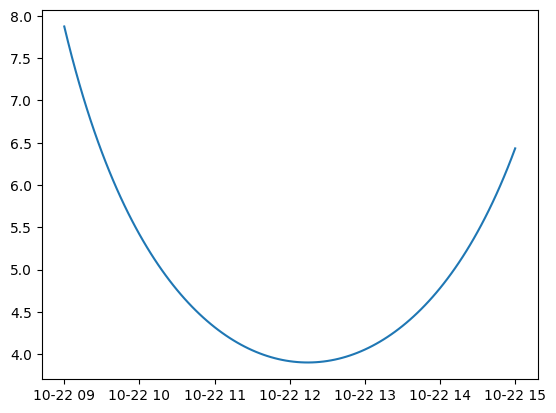

In [869]:
日期 = datetime.fromisoformat("2015-10-22")
tian_anmen_long = np.deg2rad(116 + 23 / 60 + 29 / 3600)
tian_anmen_lat = np.deg2rad(39 + 54 / 60 + 26 / 3600)
L = 3
北京时间 = np.linspace(9, 15, 6 * 20 + 1)
x_ticks = [日期 + timedelta(hours=t) for t in 北京时间]
D = (日期 - equinox_2015).days
ls = ll(D, 北京时间, tian_anmen_long, tian_anmen_lat, L)
# omegas = omega(D, 北京时间, tian_anmen_long, tian_anmen_lat)
# Ns = ls * np.cos(omegas)
# Es = ls * np.sin(omegas)

# plt.plot(Es, Ns)
plt.plot(x_ticks, ls)


[109.22892182  19.10193065]


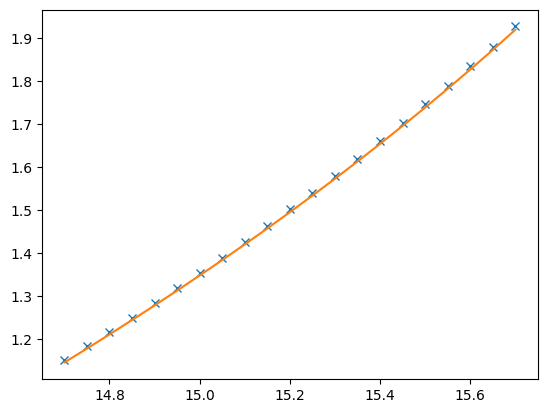

In [870]:
日期 = datetime.fromisoformat("2015-04-18")
D = (日期 - equinox_2015).days
北京时间 = np.array([(time.replace(tzinfo=None) - 日期).total_seconds() / 3600 for time in times])
ls = np.sqrt(xs ** 2 + ys ** 2)

sin_dec = declination(D)
cos_dec = np.sqrt(1 - sin_dec ** 2)


def target_function(params):
    t0, lat = params
    local_t = np.linspace(t0, t0+1, 21)
    elev = solar_elevation_angle(sin_dec, lat, local_t)
    ll = L / np.tan(elev)
    return sum((ll[1:] / ll[:-1] - ls[1:] / ls[:-1]) ** 2)


def elev_constraint(params):
    t0, lat = params
    local_t = np.linspace(t0, t0+1, 21)
    elev = solar_elevation_angle(sin_dec, lat, local_t)
    return elev


res = optimize.minimize(target_function, [14, tian_anmen_lat], bounds=[(0, 24), (0, np.pi/2)])
assert res.success
t0, lat = res.x
local_t = np.linspace(t0, t0+1, 21)
long = np.deg2rad(120) - np.deg2rad(15) * (北京时间[0] - t0)
print(np.rad2deg([long, lat]))

elev = solar_elevation_angle(sin_dec, lat, local_t)
L = 2
ll = L / np.tan(elev)

plt.plot(北京时间, ls, "x")
plt.plot(北京时间, ll)


In [871]:
equinox_2015_timestamp = datetime.fromisoformat("2015-03-20 22:45+00:00").timestamp()
obliquity_of_the_ecliptic = np.deg2rad(23.44)
seconds_per_day = 86400
days_per_year = 365.2422


def hour_angle(timestamp, longitude):
    return (timestamp % seconds_per_day / seconds_per_day - 1/2) * 2 * np.pi + longitude


def declination(timestamp):
    return np.arcsin(np.sin((timestamp - equinox_2015_timestamp) / seconds_per_day / days_per_year * 2 * np.pi) * np.sin(obliquity_of_the_ecliptic))


def solar_elevation_angle(timestamp, longitude, latitude):
    dec = declination(timestamp)
    return np.arcsin(np.cos(latitude) * np.cos(dec) * np.cos(hour_angle(timestamp, longitude)) + np.sin(latitude) * np.sin(dec))


def l(timestamp, longitude, latitude, L):
    elev = solar_elevation_angle(timestamp, longitude, latitude)
    if any(elev <= 0):
        return np.nan
    return L / np.tan(elev)


def omega(timestamp, longitude, latitude):
    dec = declination(timestamp)
    ha = hour_angle(timestamp, longitude)
    elev = solar_elevation_angle(timestamp, longitude, latitude)
    cos_omega = (np.cos(dec) * np.cos(ha) * np.sin(latitude) - np.sin(dec) * np.cos(latitude)) / np.cos(elev)
    sin_omega = np.sin(ha) * np.cos(dec) / np.cos(elev)
    return np.arctan2(sin_omega, cos_omega)


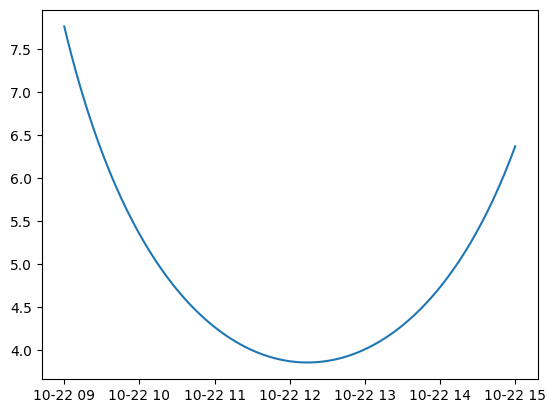

In [872]:
日期 = datetime.fromisoformat("2015-10-22 00:00:00+08:00")
tian_anmen_long = np.deg2rad(116 + 23 / 60 + 29 / 3600)
tian_anmen_lat = np.deg2rad(39 + 54 / 60 + 26 / 3600)
L = 3
x_ticks = [日期 + timedelta(hours=t) for t in np.linspace(9, 15, 6 * 20 + 1)]
timestamps = np.array([time.timestamp() for time in x_ticks])
ls = l(timestamps, tian_anmen_long, tian_anmen_lat, L)
# omegas = omega(D, 北京时间, tian_anmen_long, tian_anmen_lat)
# Ns = ls * np.cos(omegas)
# Es = ls * np.sin(omegas)

# plt.plot(Es, Ns)
plt.plot(x_ticks, ls)


In [873]:
# timestamps = np.array([time.timestamp() for time in times])
# ls = np.sqrt(xs ** 2 + ys ** 2)
# omegas = np.arctan2(ys, xs)


# def Nl_El(longitude, latitude):
#     ll = l(timestamps, longitude, latitude, 1)
#     omegal = omega(timestamps, longitude, latitude)
#     Nl = ll * np.cos(omegal)
#     El = ll * np.sin(omegal)
#     return Nl, El

# def Nsp_Esp(L, omega0):
#     Esp = ls * np.cos(omegas + omega0) / L
#     Nsp = ls * np.sin(omegas + omega0) / L
#     return Nsp, Esp


# def target_function(params):
#     longitude, latitude, L, omega0 = params
#     Nl, El = Nl_El(longitude, latitude)
#     Nsp, Esp = Nsp_Esp(L, omega0)
#     return sum((El - Esp) ** 2 + (Nl - Nsp) ** 2)


# res = optimize.minimize(target_function, [*np.deg2rad([109.22892182434902, 19.101930654140194]), 2, np.deg2rad(-14)], bounds=[np.deg2rad([80, 130]), np.deg2rad([0, 30]), (0, 3), (-np.pi, np.pi)])
# print(res)
# assert res.success
# longitude, latitude, L, omega0 = res.x
# print(np.rad2deg(longitude), np.rad2deg(latitude), L, np.rad2deg(omega0))
# # longitude, latitude = np.deg2rad([109.22892182434902, 19.101930654140194])
# # L = 2
# # omega0 = np.deg2rad(-14)
# Nl, El = Nl_El(longitude, latitude)
# Nsp, Esp = Nsp_Esp(L, omega0)

# plt.grid()
# # plt.xlim(-2, 2)
# # plt.ylim(-2, 2)
# plt.scatter(El, Nl)
# plt.scatter(Esp, Nsp, marker='x')


In [874]:
timestamps = np.array([time.timestamp() for time in times])
ls = np.sqrt(xs ** 2 + ys ** 2)
omegas = np.arctan2(ys, xs)
xs_mean = np.mean(xs)
ys_mean = np.mean(ys)
ls_mean = np.sqrt(xs_mean ** 2 + ys_mean ** 2)
omegas_mean = np.arctan2(ys_mean, xs_mean)


def Nl_El(longitude, latitude):
    ll = l(timestamps, longitude, latitude, 1)
    omegal = omega(timestamps, longitude, latitude)
    Nl = ll * np.cos(omegal)
    El = ll * np.sin(omegal)
    return Nl, El


def Nsp_Esp(L, omega0):
    Nsp = ls * np.sin(omegas + omega0) / L
    Esp = ls * np.cos(omegas + omega0) / L
    return Nsp, Esp


def L_omega0(Nl, El):
    Nl_mean = np.mean(Nl)
    El_mean = np.mean(El)
    ll_mean = np.sqrt(Nl_mean ** 2 + El_mean ** 2)
    omegal_mean = np.arctan2(El_mean, Nl_mean)
    L = ls_mean / ll_mean
    omega0 = - omegas_mean + omegal_mean
    return L, omega0


def target_function(params):
    longitude, latitude = params
    Nl, El = Nl_El(longitude, latitude)
    L, omega0 = L_omega0(Nl, El)
    Nsp, Esp = Nsp_Esp(L, omega0)
    return sum((El - Esp) ** 2 + (Nl - Nsp) ** 2)


res = optimize.minimize(target_function, [tian_anmen_long, tian_anmen_lat], bounds=[np.deg2rad([-180, 180]), np.deg2rad([-90, 90])])
print(res)
assert res.success
longitude, latitude = res.x
# longitude, latitude = np.deg2rad([109.22892182434902, 19.101930654140194])
Nl, El = Nl_El(longitude, latitude)
L, omega0 = L_omega0(Nl, El)
Nsp, Esp = Nsp_Esp(L, omega0)

print(np.rad2deg(longitude), np.rad2deg(latitude), L, np.rad2deg(omega0))

plt.grid()
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.scatter(El, Nl)
plt.scatter(Esp, Nsp, marker='x')


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 2.031e+00  6.965e-01]
      nit: 0
      jac: [ 5.156e+01  2.858e+01]
     nfev: 6
     njev: 2
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


AssertionError: 